## Import Python Module to Create/Upload New Data Instances
### (Persona: Data Engineer)

Use metaflow-based data model

In [1]:
import pandas as pd
import opal.flow
import metaflow
import os

ch10_path = '/home/jovyan/opal/resources/652200104150842.ch10'

In [2]:
# TEST_ENV is set in the test_all script
# found in opal/devops-software.
# test_flag is set to boolean true when this notebook is being tested
test_flag = False
if "TEST_ENV" in os.environ:
    test_flag = True

## Parse and Translate NASA Chapter 10 MilStd1553 and ARINC429 Data
### (Persona: Data Engineer)

In [3]:
!python /home/jovyan/opal/data-engineering-resources/tip_parse_flow.py run --c10 {ch10_path}

parse_flow = metaflow.Flow("TipParseFlow")
parse_id = parse_flow.latest_successful_run.id

!python /home/jovyan/opal/data-engineering-resources/tip_translate_flow.py run --parsed {parse_id} --type MILSTD1553 --dts /home/jovyan/opal/starter-notebooks/startup-guide/DTS1553_Synth_Nasa.yaml
!python /home/jovyan/opal/data-engineering-resources/tip_translate_flow.py run --parsed {parse_id} --type ARINC429 --dts /home/jovyan/opal/starter-notebooks/startup-guide/DTS429_Synth_NASA.yaml

Metaflow 2.7.7 executing TipParseFlow for user:jovyan
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2022-12-09 23:07:30.568 Workflow starting (run-id 1670627250445111):
2022-12-09 23:07:30.585 [1670627250445111/start/1 (pid 171)] Task is starting.
2022-12-09 23:07:32.631 [1670627250445111/start/1 (pid 171)] Task finished successfully.
2022-12-09 23:07:32.672 [1670627250445111/parse/2 (pid 201)] Task is starting.
2022-12-09 23:07:33.726 [1670627250445111/parse/2 (pid 201)] GetTerminalSize(): Call to ioctl failed
2022-12-09 23:07:34.407 [1670627250445111/parse/2 (pid 201)] CLIGroup(): Failed to get terminal size
2022-12-09 23:07:34.448 [1670627250445111/parse/2 (pid 201)] Task finished successfully.
2022-12-09 23:07:34.486 [1670627250445111/extract_metadata/3 (pid 235)] Task is starting.
2022-12-09 23:07:35.508 [1670627250445111/extract_metadata/3 (pid 235)] Found metadata for parsed_MILSTD1553_F1
2022-12-09 23:07:35.514 [1670627250445111/extrac

## Segue To OPAL Catalog

1. (Upper left) Select "File" --> "Hub Control Panel"
2. (Hub Control Panel Tab) Select "Services" --> "opal-catalog"
3. (OPAL Catalog Tab) Select "Login with Keycloak"
4. Click "Edit Columns" button and add "CH10 NAME"
5. Place cursor in "Search Catalog" field
6. Type "ch10", arrow down to select suggestion "kind_metadata.ch10_name", then press Enter
7. Search Catalog for ch10 name "652200104150842" -- No entry! Data have not been published.
8. Clear search bar and Enter to reset search
9. Return to notebook tab, see "Publish Datasets To Searchable Catalog"

## Publish Datasets to Searchable Catalog
### (Persona: Data Engineer)

In [4]:
print(f"Publishing parsed run {parse_flow.latest_successful_run.id}")
print(opal.flow.publish_run(parse_flow.latest_successful_run))

translate_flow = metaflow.Flow("TipTranslateFlow")
for run in translate_flow:
    if run.successful and run.data.parse_run.id == parse_id:
        print(f"Publishing translated run {run.id}")
        print(opal.flow.publish_run(run))

Publishing parsed run 1670627250445111
(True, 201)
Publishing translated run 1670627284369464
(True, 201)
Publishing translated run 1670627266396413
(True, 201)


## View Published Data in Catalog

1. Return to OPAL Catalog tab
2. Click "Edit Columns" button and add "CH10 NAME"
3. Place cursor in "Search Catalog" field
4. Type "ch10", arrow down to select suggestion "kind_metadata.ch10_name", then press Enter
5. Cursor is placed in quotes, type "652200104150842", press Enter
6. Notice the relevant ch10 name in the CH10 NAME column 
7. Click on links in "Kind ID" column to view metadata

## Read Datasets from Catalog
### (Persona: Analyst)
#### Latitude/Longitude/Altitude (1553)

Run metadata automatically included in the catalog can be searched

In [5]:
import opal.query
inst = opal.query.search.Instance()

arinc429_result = inst._with("parse_pointer", parse_id)._and("translate_type", "ARINC429").search().all()[0]
arinc429_id = arinc429_result["kind_id"]
mil1553_id = inst._with("parse_pointer", parse_id)._and("translate_type", "MILSTD1553").search().all()[0]["kind_id"]

display(arinc429_result)

{'kind_id': '1670627284369464',
 'kind_type': 'TipTranslateFlow',
 'kind_metadata': {'id': '1670627284369464',
  'dts': '/home/jovyan/opal/starter-notebooks/startup-guide/DTS429_Synth_NASA.yaml',
  'name': 'TipTranslateFlow',
  'tags': ['python_version:3.9.7',
   'runtime:dev',
   'metaflow_version:2.7.7',
   'user:jovyan'],
  'dtemp': '/tmp/tmpjwmtpelf/parse_data.parquet',
  's3root': 'metaflow-data/data/TipTranslateFlow/1670627284369464',
  'flow_id': 'TipTranslateFlow',
  'temp_dir': '/home/jovyan/translated_data',
  'parse_run': "Run('TipParseFlow/1670627250445111')",
  'created_at': '2022-12-09 23:08:04.370000',
  'data_files': {'translated_data': 'metaflow-data/data/TipTranslateFlow/1670627284369464/translated_data'},
  'successful': True,
  'tip_metadata': {'translated_ARINC429_F0': {'uid': '3767e2062a97f83f68ac78274228ca898e4e56200d47943224d0241ccae6d970',
    'type': 'translated_ARINC429_F0',
    'config': {'prompt_user': False,
     'vote_threshold': 1,
     'auto_sys_limits'

# Analyze Data in New Dataset
Latitude/Longitude/Altitude (1553)

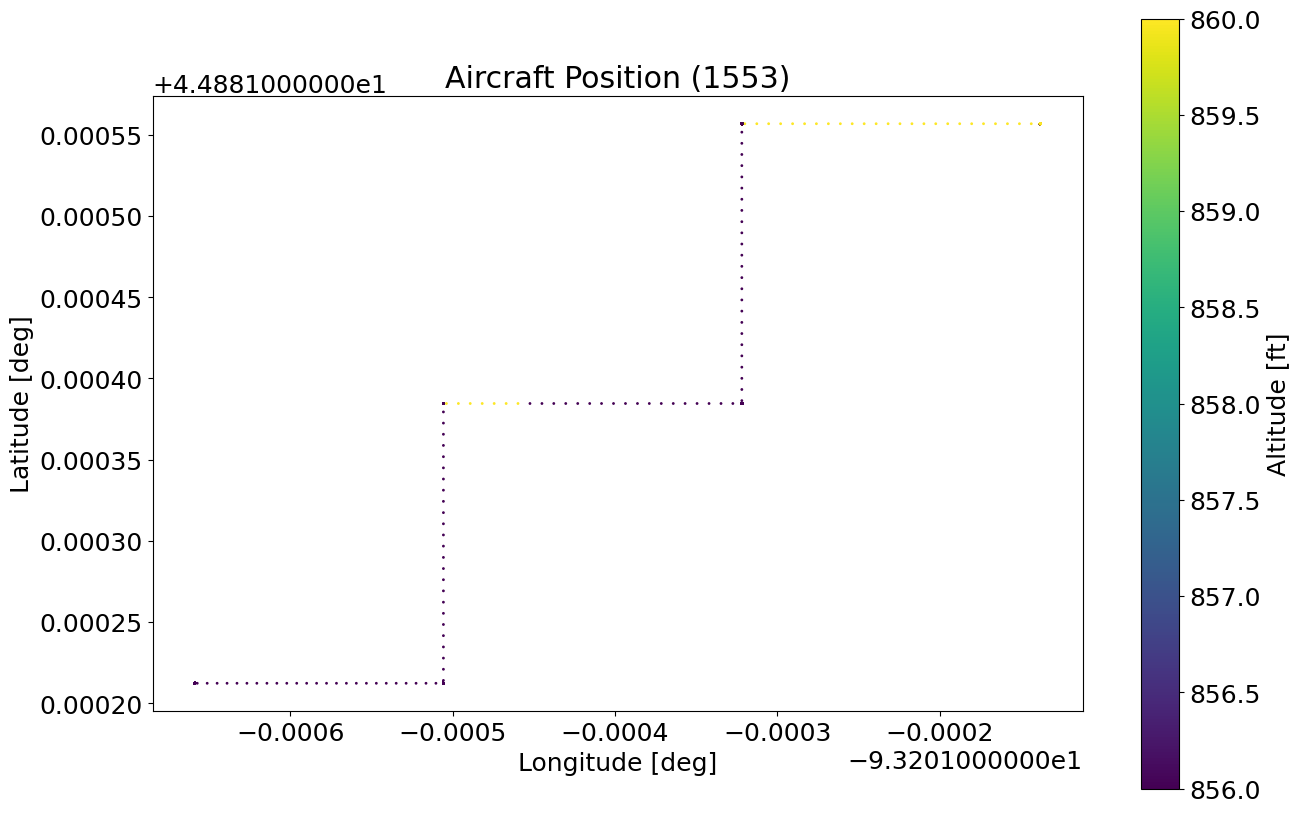

In [6]:
import matplotlib.pyplot as plt
import os

# Construct the path to the parquet file in S3
s3 = opal.flow.minio_s3fs()
parquet_path = translate_flow[mil1553_id].data.data_files['translated_data']
parquet_path = os.path.join(parquet_path, "parse_data_translated", "NAV.parquet")

# Read it with Pandas
df_1553 = pd.read_parquet(parquet_path, filesystem=s3)

# Filter out invalid lat/long/altitude measurements
where_valid = df_1553[df_1553["NAV-0110"] & df_1553["NAV-0111"]]
plt.rcParams.update({"font.size":18})

# plot
fig, ax = plt.subplots()
ax = where_valid.plot(
    kind="scatter", title="Aircraft Position (1553)",
    x="NAV-23", y="NAV-21", c="NAV-25", s=1,
    cmap="viridis", figsize=(15, 10), ax=ax)

ax.set_aspect("equal")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
plt.gcf().get_axes()[1].set_ylabel("Altitude [ft]")
None

#### Engine Status (ARINC429) with Altitude (1553)

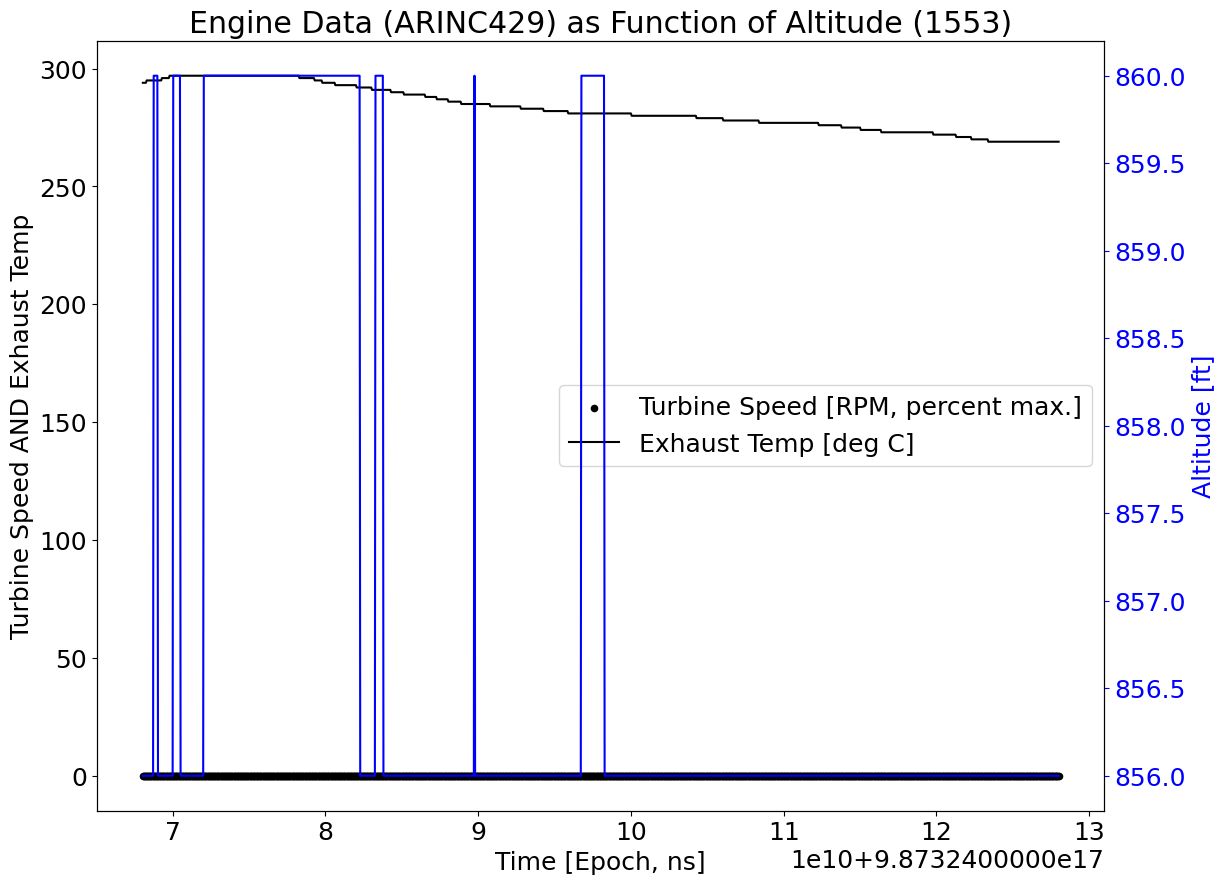

In [7]:
arinc429_path = translate_flow[arinc429_id].data.data_files['translated_data']
arinc429_path = os.path.join(arinc429_path, "parse_data_translated")

turbine_speed_path = os.path.join(arinc429_path, "Engine_Turbine_RPM_40.parquet")
exhaust_temp_path = os.path.join(arinc429_path, "Exhaust_Gas_Temperature_40.parquet")

df_turbine_speed = pd.read_parquet(turbine_speed_path, filesystem=s3)
df_exhaust_temp = pd.read_parquet(exhaust_temp_path, filesystem=s3)

ax = df_turbine_speed.plot(kind="scatter", x="time", y="N2_RPM", figsize=(13, 10), c='k', label="Turbine Speed [RPM, percent max.]")
ax.set_ylabel(r'Turbine Speed AND Exhaust Temp', c='k')
ax.tick_params(axis='y', colors='k')
df_exhaust_temp.plot(kind="line", x="time", y="Exhaust_Gas_Temperature", ax=ax, c='k', label="Exhaust Temp [deg C]")
ax2 = where_valid.plot(kind="line", x="time", y="NAV-25", secondary_y=True, c='b', ax=ax)
ax2.set_ylabel("Altitude [ft]", c='b')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax.set_xlabel("Time [Epoch, ns]")
ax.legend()
title = ax.set_title("Engine Data (ARINC429) as Function of Altitude (1553)")
None

# Delete data for next run

In [8]:
opal.flow.delete_run_data(parse_flow[parse_id])
opal.flow.delete_run_data(translate_flow[arinc429_id])
opal.flow.delete_run_data(translate_flow[mil1553_id])